Importing libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from imageio import imread
from skimage.transform import resize
from scipy.spatial import distance
from keras.models import load_model
from google.colab import files

In [38]:
files.upload()

Saving image2.jpg to image2.jpg


{'image2.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xfe\x00;CREATOR: gd-jpeg v1.0 (using IJG JPEG v62), quality = 85\n\xff\xdb\x00C\x00\x05\x03\x04\x04\x04\x03\x05\x04\x04\x04\x05\x05\x05\x06\x07\x0c\x08\x07\x07\x07\x07\x0f\x0b\x0b\t\x0c\x11\x0f\x12\x12\x11\x0f\x11\x11\x13\x16\x1c\x17\x13\x14\x1a\x15\x11\x11\x18!\x18\x1a\x1d\x1d\x1f\x1f\x1f\x13\x17"$"\x1e$\x1c\x1e\x1f\x1e\xff\xdb\x00C\x01\x05\x05\x05\x07\x06\x07\x0e\x08\x08\x0e\x1e\x14\x11\x14\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\x1e\xff\xc2\x00\x11\x08\x048\x07\x80\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x01\x01\x00\x03\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\xff\xc4\x00\x19\x01\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\xff\xda\x00\x0c\

In [112]:
image_dir_basepath = 'images/'
names = ['ElonMusk', 'MarkZuckerberg', 'BillGates']
image_size = 160

Loading facenet_keras

In [17]:
model = load_model('facenet_keras.h5')

This functions normalize picture.

In [18]:
def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y

In [19]:
def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

This function displays an image

In [20]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

This function makes cropping and aligning images.

In [65]:
def load_and_align_images(filepaths, margin):
    cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt2.xml')
    
    aligned_images = []
    for filepath in filepaths:
        img = imread(filepath)

        faces = cascade.detectMultiScale(img,
                                         scaleFactor=1.1,
                                         minNeighbors=3)
        (x, y, w, h) = faces[0]
        cropped = img[y-margin//2:y+h+margin//2,
                      x-margin//2:x+w+margin//2, :]
        aligned = resize(cropped, (image_size, image_size), mode='reflect')
        aligned_images.append(aligned)

    return np.array(aligned_images)

This function calculates embedding vector.

In [22]:
def calc_embs(filepaths, margin=10, batch_size=1):
    aligned_images = prewhiten(load_and_align_images(filepaths, margin))
    pd = []
    for start in range(0, len(aligned_images), batch_size):
        pd.append(model.predict_on_batch(aligned_images[start:start+batch_size]))
    embs = l2_normalize(np.concatenate(pd))

    return embs

This function measures Euclidean distance between two vectors.

In [23]:
def calc_dist(pos1, pos2):
    return distance.euclidean(pos1, pos2)

This fucntion plots two images

In [117]:
def plot_images(img1, img2):
    plt.subplot(1, 2, 1)
    plt.imshow(imread(data[img1]['image_filepath']))
    plt.subplot(1, 2, 2)
    plt.imshow(imread(data[img2]['image_filepath']))

This function checks for similarity of two pictures

In [169]:
def is_similar(img1, img2, threshold=0.75):
    plot_images(img1, img2)
    dist = calc_dist(data[img1]['emb'], data[img2]['emb'])

    print("distance: {}".format(dist))

    if dist <= threshold:
        print("{}% of confidence".format((1 - dist / threshold + 0.4) * 100))

        return True
    else:
        return False

Getting all embedding vectors for the pictures.

In [170]:
data = {}
for name in names:
    image_dirpath = image_dir_basepath + name
    image_filepaths = [os.path.join(image_dirpath, f) for f in os.listdir(image_dirpath)]
    embs = calc_embs(image_filepaths)
    for i in range(len(image_filepaths)):
        data['{}{}'.format(name, i)] = {'image_filepath' : image_filepaths[i],
                                        'emb' : embs[i]}

Some examples

distance: 1.4206382036209106
It's the same person: False


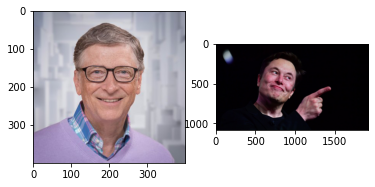

In [171]:
print("It's the same person: {}".format(is_similar("BillGates0", "ElonMusk0")))

distance: 0.5091050267219543
72.1193297704061% of confidence
It's the same person: True


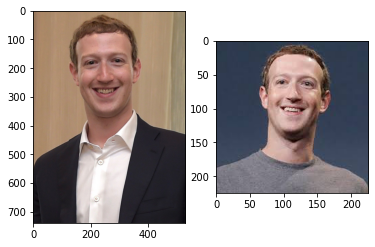

In [172]:
print("It's the same person: {}".format(is_similar("MarkZuckerberg0", "MarkZuckerberg1")))

distance: 0.41043347120285034
85.27553717295329% of confidence
It's the same person: True


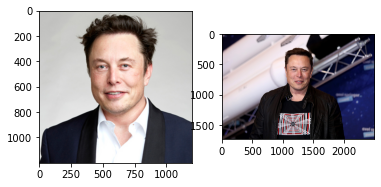

In [173]:
print("It's the same person: {}".format(is_similar("ElonMusk1", "ElonMusk2")))

distance: 1.17404305934906
It's the same person: False


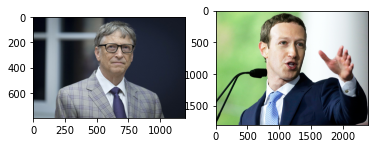

In [174]:
print("It's the same person: {}".format(is_similar("BillGates2", "MarkZuckerberg2")))

distance: 0.7355360984802246
41.92852020263672% of confidence
It's the same person: True


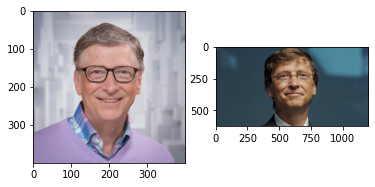

In [175]:
print("It's the same person: {}".format(is_similar("BillGates0", "BillGates1")))

Creating 3D space with our embedding vectors

In [130]:
X = []
for v in data.values():
    X.append(v['emb'])
pca = PCA(n_components=3).fit(X)

In [131]:
X_BillGates = []
X_ElonMusk = []
X_MarkZuckerberg = []
for k, v in data.items():
    if 'Bill' in k:
        X_BillGates.append(v['emb'])
    elif 'Elon' in k:
        X_ElonMusk.append(v['emb'])
    elif 'Mark' in k:
        X_MarkZuckerberg.append(v['emb'])
        
Xd_BillGates = pca.transform(X_BillGates)
Xd_ElonMusk = pca.transform(X_ElonMusk)
Xd_MarkZuckerberg = pca.transform(X_MarkZuckerberg)

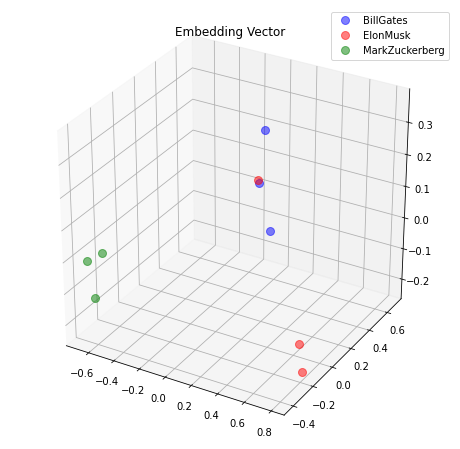

In [132]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 10   
ax.plot(Xd_BillGates[:,0], Xd_BillGates[:,1], Xd_BillGates[:,2],
        'o', markersize=8, color='blue', alpha=0.5, label='BillGates')
ax.plot(Xd_ElonMusk[:,0], Xd_ElonMusk[:,1], Xd_ElonMusk[:,2],
        'o', markersize=8, color='red', alpha=0.5, label='ElonMusk')
ax.plot(Xd_MarkZuckerberg[:,0], Xd_MarkZuckerberg[:,1], Xd_MarkZuckerberg[:,2],
        'o', markersize=8, color='green', alpha=0.5, label='MarkZuckerberg')

plt.title('Embedding Vector')
ax.legend(loc='upper right')

plt.show()